In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
test_signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.full_signal_list)])
test_bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])

100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


In [16]:
print('\n'.join((test_signal).apply( lambda t : str(ak.sum(t.nfound_select==8))).objs))

3612
4334
4613
4773
5529
4807
6494
8838


In [10]:
print('\n'.join((test_signal+test_bkg).apply( lambda t : str(len(t))).objs))

52507
56712
58110
58700
61976
59804
65108
70448
246944


In [5]:
train_signal = ObjIter([Tree(f, report=False, altfile='train_{base}') for f in tqdm(module.full_signal_list)])
train_bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='train_{base}')])

100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


In [14]:
train_signal = ObjIter([Tree(f, report=False, altfile='split_0_reweight_eightb_train_{base}') for f in tqdm(module.full_signal_list)])
train_bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='split_0_reweight_train_{base}')])

100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


In [15]:
print('\n'.join((train_signal+train_bkg).apply( lambda t : str(5*len(t))).objs))

144510
171170
182845
186960
220960
286075
260170
359310
983510


In [26]:
def get_mu_sig(h):
    print(h.stats.mean,',', 1/h.stats.stdv)
    # return f'${h.stats.mean:0.2f}\pm{h.stats.stdv:0.2f}$'
    return f'{h.stats.nevents:0.2f}'

  0%|          | 0/4 [00:00<?, ?it/s]

69.43642953544958 , 0.029673644978592838


 25%|██▌       | 1/4 [00:01<00:04,  1.47s/it]

48.2336678879313 , 0.03393010088023426
11.572852033316977 , 0.17912720313498826


 50%|█████     | 2/4 [00:02<00:02,  1.48s/it]

9.526298000215299 , 0.1853833302200142
-0.005192855261308184 , 1.0361635410384744


 75%|███████▌  | 3/4 [00:04<00:01,  1.50s/it]

-0.002998155767621328 , 0.7766736959414724
-0.0010373801866720564 , 0.5508999453035716


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

0.0030436610059786586 , 0.549882559701506


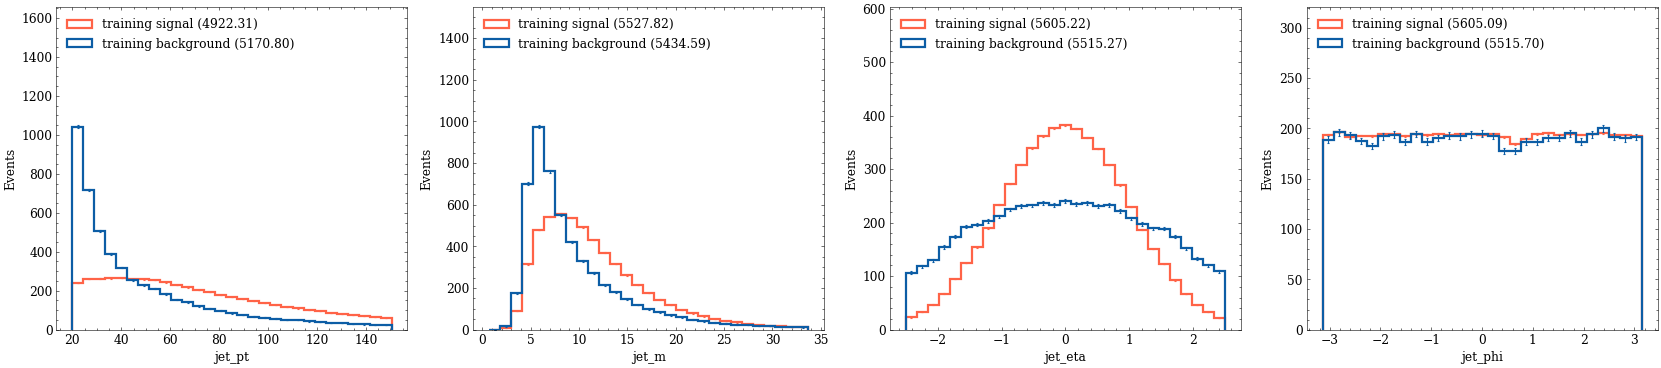

In [28]:
study.quick_region(
    train_signal,train_bkg,
    label=['training signal','training background'],
    varlist=['jet_pt','jet_m','jet_eta','jet_phi'],
    lumi=None,
    scale=lambda t: (1/8 if t.is_signal else 1) * t.dataset_norm_abs_scale/t.scale,
    h_label_stat=get_mu_sig,
    legend=True,
    dim=-1,
)

  0%|          | 0/4 [00:00<?, ?it/s]

105.27816002856378 , 0.011009209039279932
58.836026174379356 , 0.021132491567278713


 25%|██▌       | 1/4 [00:00<00:01,  1.82it/s]

881.2609032618407 , 0.0060739561867023005


 50%|█████     | 2/4 [00:01<00:01,  1.87it/s]

917.5913756066626 , 0.0031212260082051847
-0.02217258443451149 , 0.38881936806213063


 75%|███████▌  | 3/4 [00:01<00:00,  1.88it/s]

-0.008510039588514989 , 0.35967897056049625
-0.017231909071661677 , 0.5485581461089167


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

-0.03045782103116932 , 0.5467026432662647


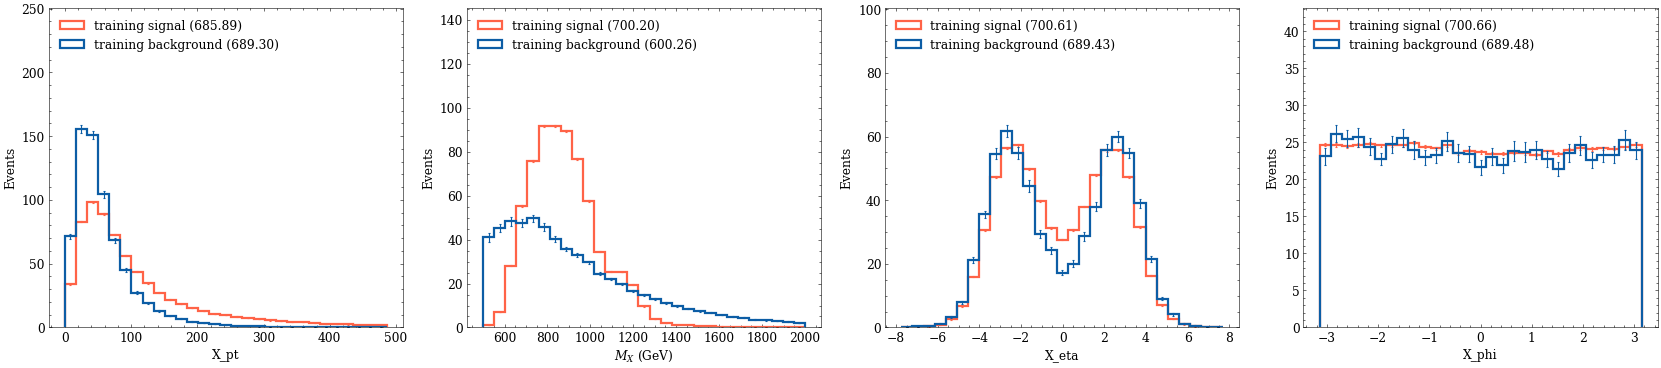

In [29]:
study.quick_region(
    train_signal,train_bkg,
    label=['training signal','training background'],
    varlist=['X_pt','X_m','X_eta','X_phi'],
    lumi=None,
    scale=lambda t: (1/8 if t.is_signal else 1) * t.dataset_norm_abs_scale/t.scale,
    h_label_stat=get_mu_sig,
    legend=True,
    dim=-1,
)

In [31]:
def get_reco(jet_p4, perm):
    p4 = jet_p4[perm]

    h_p4 = p4[:,::2] + p4[:,1::2]
    y_p4 = h_p4[:,::2] + h_p4[:,1::2]
    x_p4 = y_p4[:,0] + y_p4[:,1]

    y_rank = ak_rank( y_p4.pt, axis=1 )
    x_yy_order = ak.argsort(y_rank, ascending=True)

    y_h_rank = ak.unflatten(
            np.repeat(y_rank, 2),
            ak.count(h_p4.pt,axis=1),
        )
    h_rank = ak_rank( h_p4.pt, axis=1 )
    x_yy_4h_order = ak.argsort( 10*y_h_rank + h_rank, ascending=True )

    y_h_j_rank = ak.unflatten(
            np.repeat(y_h_rank, 2),
            ak.count(p4.pt,axis=1),
        )
    j_rank = ak_rank(p4.pt, axis=1)
    x_yy_4h_8b_order = ak.argsort( 100*y_h_j_rank + j_rank, ascending=True)

    y_p4_ordered = y_p4[x_yy_order]
    h_p4_ordered = h_p4[x_yy_4h_order]
    j_p4_ordered = p4[x_yy_4h_8b_order]
    

    return x_p4, y_p4_ordered, h_p4_ordered, j_p4_ordered

In [34]:
def reco_truth(t):
    if not t.is_signal: return

    jp4 = build_p4(t, 'jet', extra=['signalId'])
    perm = ak.argsort(jp4.signalId, axis=1)

    x_p4, y_p4, h_p4, j_p4 = get_reco(jp4, perm)

    t.extend(
        gen_reco_Y1_m=y_p4.m[:,0]
    )

train_signal.apply(reco_truth)
    

[None, None, None, None, None, None, None, None]

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

881.2609032618407 , 0.0060739561867023005
322.4712992000311 , 0.011747641782014349


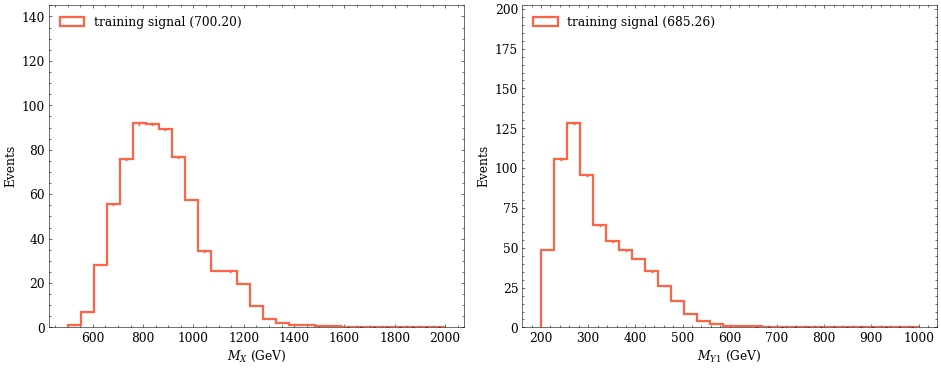

In [36]:
study.quick_region(
    train_signal,
    label=['training signal'],
    varlist=['X_m','gen_reco_Y1_m'],
    lumi=None,
    scale=lambda t: (1/8 if t.is_signal else 1) * t.dataset_norm_abs_scale/t.scale,
    h_label_stat=get_mu_sig,
    legend=True,
    dim=-1,
)

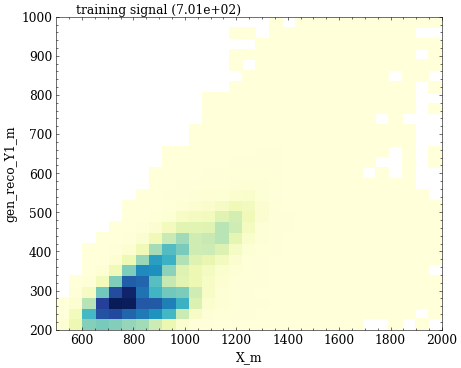

In [37]:
study.quick2d_region(
    train_signal,
    label=['training signal'],
    varlist=['X_m','gen_reco_Y1_m'],
    lumi=None,
    scale=lambda t: (1/8 if t.is_signal else 1) * t.dataset_norm_abs_scale/t.scale,
    # h_label_stat=get_mu_sig,
    legend=True,
    dim=-1,
)

In [ ]:
study.quick_region(
    train_signal,train_bkg,
    label=['training signal','training background'],
    varlist=['jet_pt','jet_m','jet_eta','jet_phi'],
    masks=lambda t : t.
    lumi=None,
    scale=lambda t: (1/8 if t.is_signal else 1) * t.dataset_norm_abs_scale/t.scale,
    h_label_stat=get_mu_sig,
    legend=True,
    dim=-1,
)

 25%|██▌       | 1/4 [00:06<00:18,  6.32s/it]

4.255691241247879 1.6083895355604323


 50%|█████     | 2/4 [00:12<00:12,  6.23s/it]

2.354848468782021 2.06583950319184


 75%|███████▌  | 3/4 [00:18<00:06,  6.34s/it]

-0.0013558181858170655 1.4143670049781705


100%|██████████| 4/4 [00:24<00:00,  6.10s/it]

-0.0008508913122464541 1.414168919168305


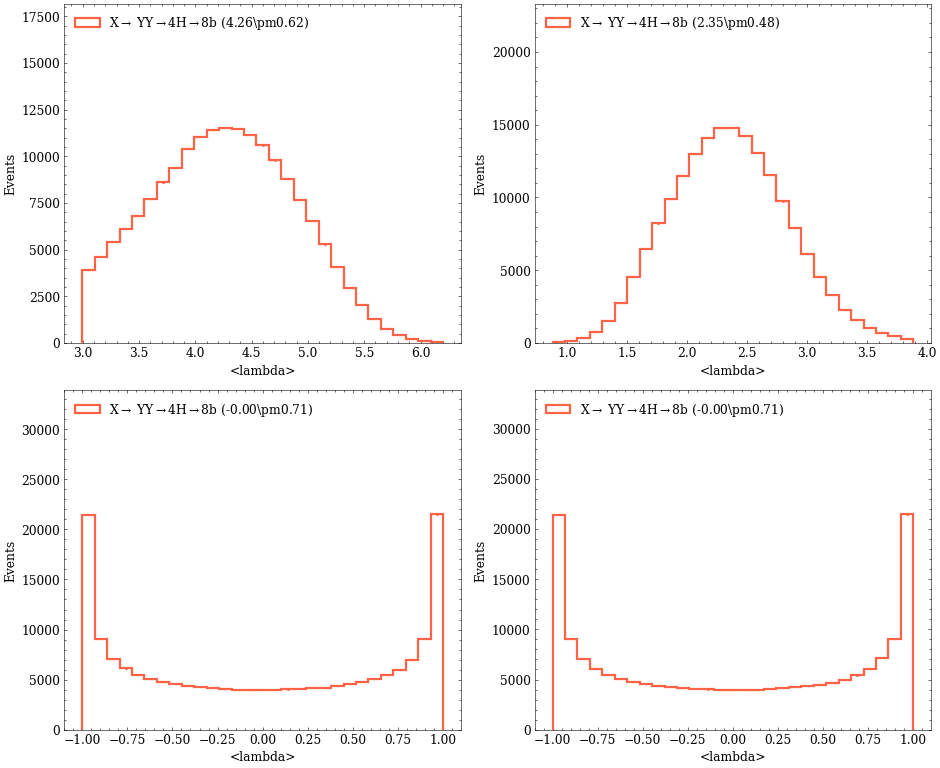

In [42]:
study.quick(
    [sigtree],
    varlist=[lambda t : np.log(t.jet_pt),lambda t : np.log(t.jet_m), lambda t : np.cos(t.jet_phi), lambda t : np.sin(t.jet_phi)],
    scale=lambda t:t.dataset_norm_abs_scale/t.scale,
    lumi=None,

    h_label_stat=get_mu_sig,
    legend=True,
)

100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


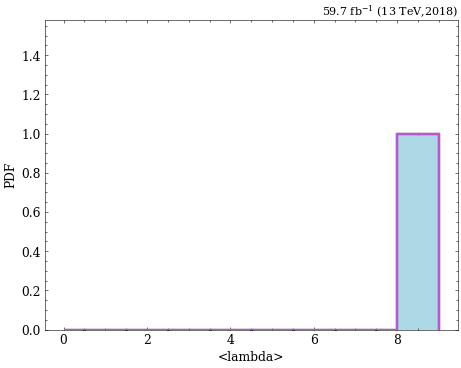

In [7]:
study.quick(
    signal + bkg,
    varlist=[lambda t : ak.count(t.jet_pt, axis=1)],
    efficiency=True
)

In [8]:
(signal + bkg).apply(lambda t: (t.sample, len(t)))

[('MX_700_MY_300', 2627065), ('MX_1000_MY_450', 3258442), ('MX_1200_MY_500', 3507074), ('QCD', 1231185)]

In [33]:
def random_sample(t, frac=0.2):
    rand_mask = np.random.random(size=len(t)) < frac
    t.extend(random_mask=rand_mask)



In [34]:
(signal+bkg).apply(random_sample)

[None, None, None, None]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


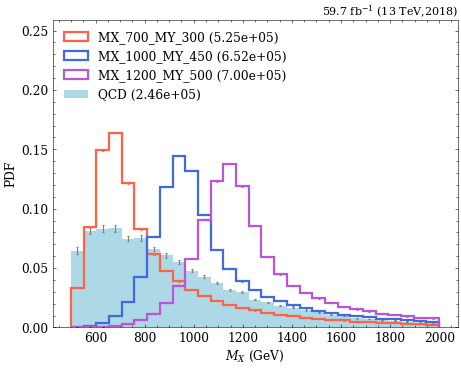

In [37]:
study.quick(
    signal + bkg,
    masks=lambda t : t.random_mask,
    varlist=['X_m'],

    efficiency=True,
    h_label_stat=lambda h : f'{len(h.array):0.2e}',
    legend=True,
)

In [48]:
trg_pt = [75,60,45,40]

def trg_pt_mask(t, trg_pt=trg_pt):
    jet_pt = t.jet_pt

    mask = jet_pt[:,0] > 0
    for i, pt_ths in enumerate(trg_pt):
        mask = mask & (jet_pt[:,i] > pt_ths)
    
    return mask

def trg_ht_mask(t):
    jet_pt = t.jet_pt 

    jet_ht = ak.sum(jet_pt[jet_pt > 30], axis=1)
    return jet_ht > 330


In [52]:
(signal + bkg).apply(lambda t: (t.sample, ak.mean(trg_pt_mask(t) & trg_ht_mask(t))))

[('MX_700_MY_300', 0.924493303363259), ('MX_1000_MY_450', 0.9929002879290164), ('MX_1200_MY_500', 0.9972797836601109), ('QCD', 0.8804265808956412)]

100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


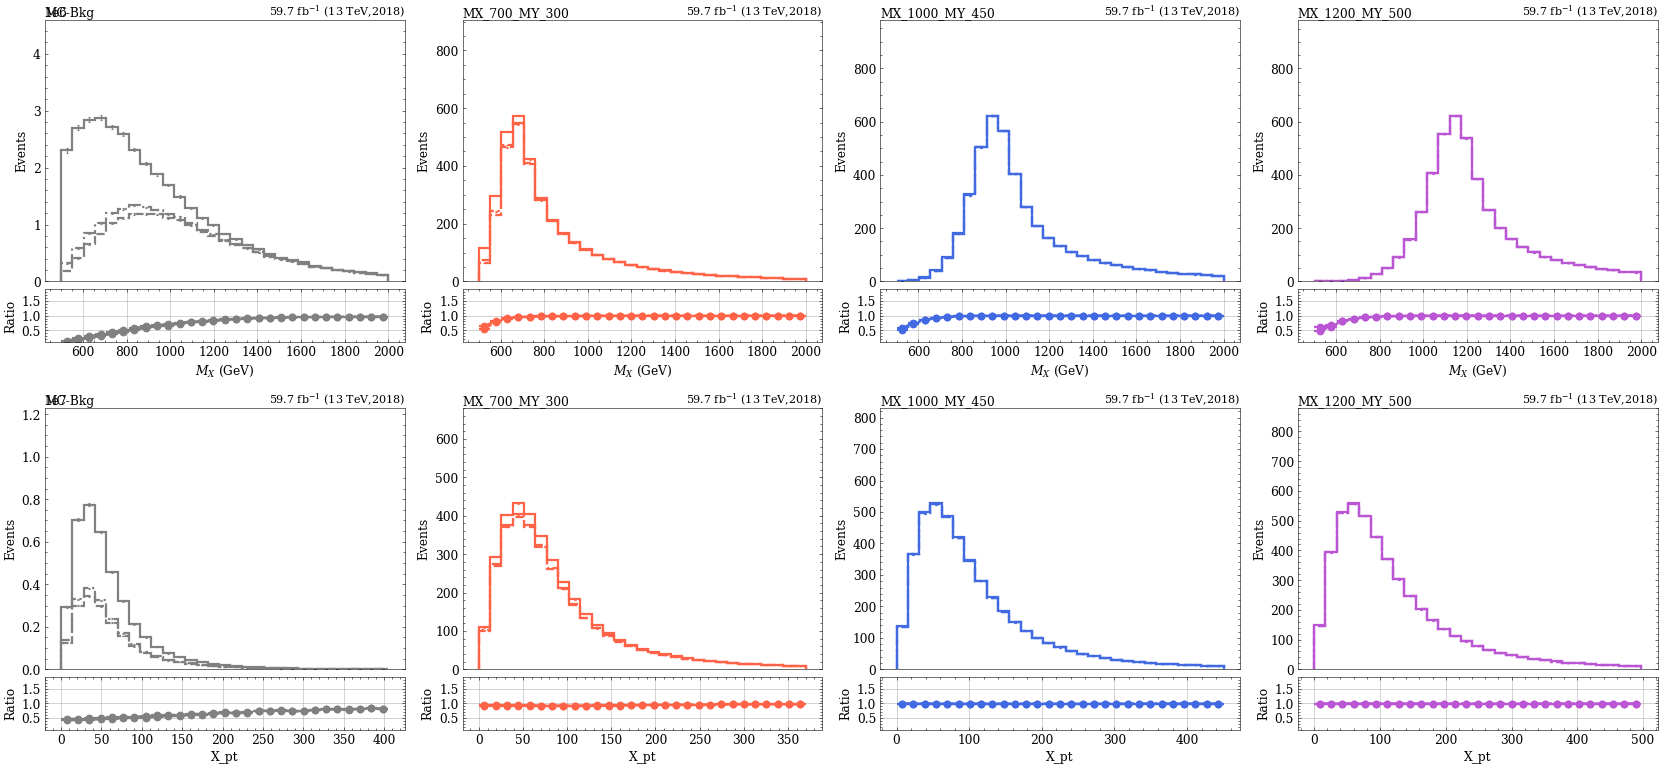

In [54]:
study.compare_masks(
    signal,bkg, 
    masks=[None, trg_pt_mask, lambda t : trg_pt_mask(t) & trg_ht_mask(t)],
    varlist=['X_m','X_pt'],
    # efficiency=True,
    ratio=True, r_inv=True,
)

In [56]:
def trg_mask(t):
    return trg_pt_mask(t) & trg_ht_mask(t)

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


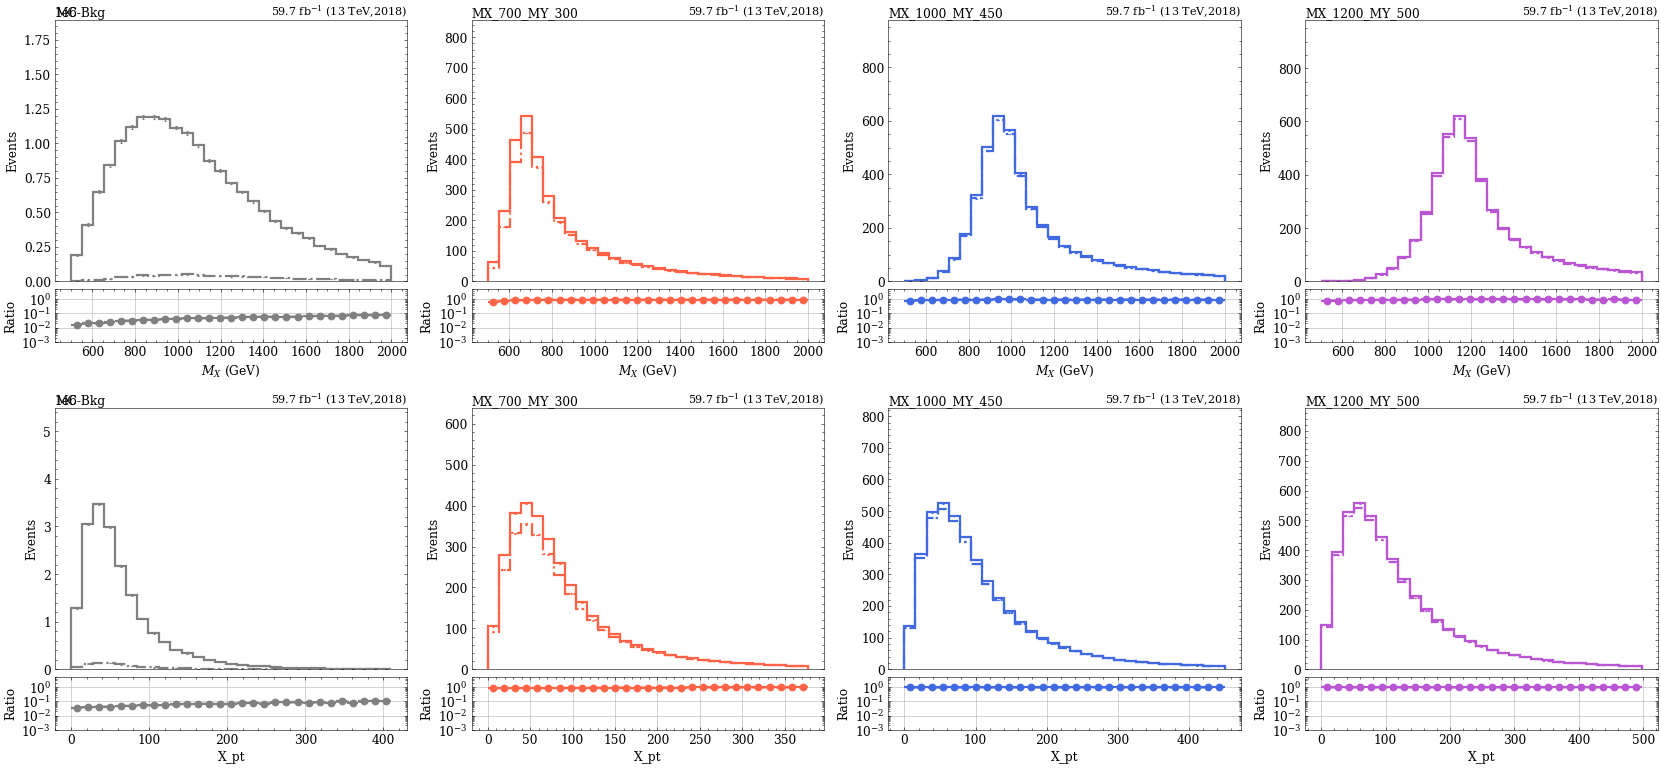

In [59]:
study.compare_masks(
    signal,bkg, 
    masks=[trg_mask, lambda t : trg_mask(t) & (t[trigger]==1)],
    varlist=['X_m','X_pt'],
    # efficiency=True,
    ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,5e0)
)

100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


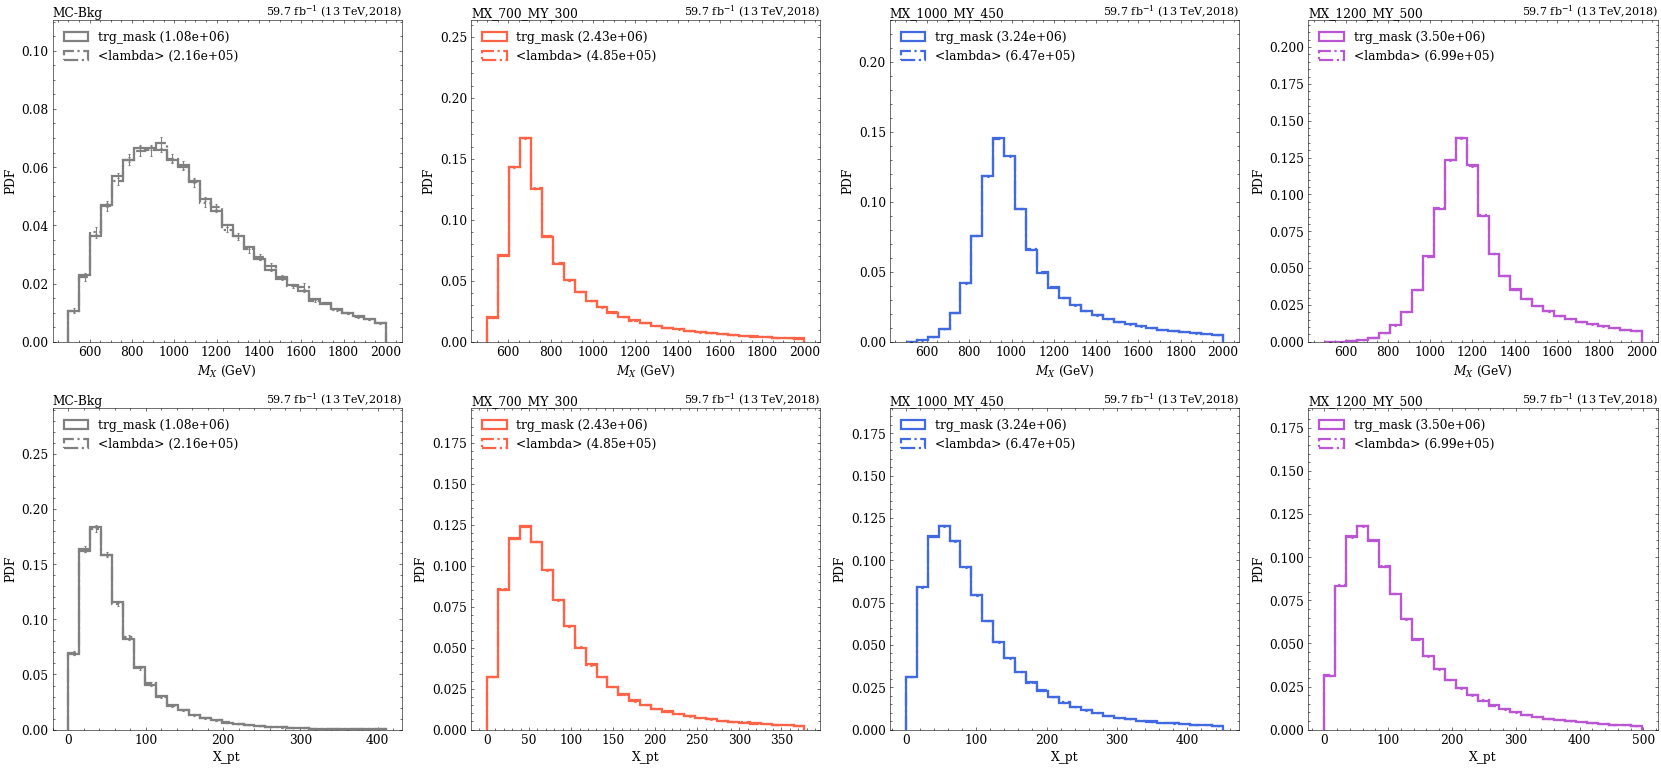

In [61]:
study.compare_masks(
    signal,bkg, 
    masks=[trg_mask, lambda t : trg_mask(t) & (t.random_mask)],
    varlist=['X_m','X_pt'],
    efficiency=True,
    legend=True,
    h_label_stat=lambda h : f'{len(h.array):0.2e}'
    # ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,5e0)
)